# Homework 5
### ASTR-324, Spring 2018, Ivezic & Juric, University of Washington
https://github.com/uw-astr-324-s18/astr-324-s18/homeworks/Astr324-S18-HW5.ipynb


## Problem

Below in the notebook is the code that generates Figure 10.17 in the textbook. As it is now, it:
* downloads a dataset of variable stars collected with the [LINEAR](https://en.wikipedia.org/wiki/Lincoln_Near-Earth_Asteroid_Research) telescope,
* selects six of them (as given by the `ids` variable),
* computes the Lomb-Scargle periodogram in the `compute_best_frequencies` function,
* finds the best frequency by looking for the highest peak in the periodiogram, and
* folds the light curves and plots the results.

Either by modifying the code below, or by writing similar code, do the following:

1. Find the frequencies for the first 100 stars in the LINEAR datasets (i.e., those with IDs in `data.ids[:100]`, where `data` is the variable containing the LINEAR dataset as defined below).

2. Compute the periods corresponing to the frequencies above, and plot the histogram of periods using 50 bins in range $0 < T < 25$ hours. What do you observe in the histogram?

3. Generate two 6-panel figures analogous to Figure 10.17, for 6 stars (arbitrarily chosen) from the highest and second highest peak, respectivelly. Comment on (dis)similarities of the two plots and of stars within each plot.

4. EXTRA CREDIT: compute the histogram in #2 for ALL (about 7000) stars in the data set, not just the first 100 (note: this will take a while - on a Mac Pro about 5 hours). Modify the histogram range and bin sizes as needed to bring out the features (clusters) in the data. Comment on differences compared to the 100-star case. Extra credit 20% of this homework! 

In [4]:
# Figure 10.17 code

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from astroML.decorators import pickle_results
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit
from astroML.datasets import fetch_LINEAR_sample

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Compute the best frequencies
@pickle_results('LINEAR_LS.pkl')
def compute_best_frequencies(ids, n_eval=10000, n_retry=5, generalized=True):
    results = {}
    for i in ids:
        t, y, dy = data[i].T
        print(" - computing power for %i (%i points)" % (i, len(t)))
        kwargs = dict(generalized=generalized)
        omega, power = search_frequencies(t, y, dy, n_eval=n_eval,
                                          n_retry=n_retry,
                                          LS_kwargs=kwargs)
        results[i] = [omega, power]

    return results

# plot phased light curves 
def plot_lightcurves(results, ids):
    #------------------------------------------------------------
    # Plot the phased light-curves
    fig = plt.figure(figsize=(5, 6.5))
    fig.subplots_adjust(hspace=0.1, bottom=0.06, top=0.94, left=0.12, right=0.94)

    for i in range(len(ids)):
        # get the data and best-fit angular frequency
        t, y, dy = data[ids[i]].T
        omega, power = results[ids[i]]
        omega_best = omega[np.argmax(power)]
        print(" - omega_0 = %.10g" % omega_best)

        # do a fit to the first 4 Fourier components
        mtf = MultiTermFit(omega_best, 4)
        mtf.fit(t, y, dy)
        phase_fit, y_fit, phased_t = mtf.predict(1000, return_phased_times=True)

        # plot the phased data and best-fit curves
        ax = fig.add_subplot(321 + i)
        ax.errorbar(phased_t, y, dy, fmt='.k', ecolor='gray',
                    lw=1, ms=4, capsize=1.5)
        ax.plot(phase_fit, y_fit, '-b', lw=2)

        ax.set_xlim(0, 1)
        ax.set_ylim(plt.ylim()[::-1])
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))

        ax.text(0.03, 0.04, "ID = %i" % ids[i], ha='left', va='bottom',
                transform=ax.transAxes)
        ax.text(0.03, 0.96, "P = %.2f hr" % (2 * np.pi / omega_best * 24.),
                ha='left', va='top',
                transform=ax.transAxes)

        ylim = ax.get_ylim()
        ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))

        if i < 4:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        if i % 2 == 0:
            ax.set_ylabel('mag')

        if i in (4, 5):
            ax.set_xlabel('phase')

    return fig 

In [6]:
# Load the dataset
data = fetch_LINEAR_sample()

@pickle_results: using precomputed results from 'LINEAR_LS.pkl'
 - omega_0 = 17.21695506
 - omega_0 = 51.10600808
 - omega_0 = 10.20062676
 - omega_0 = 45.55493503
 - omega_0 = 58.44512277
 - omega_0 = 10.82722772


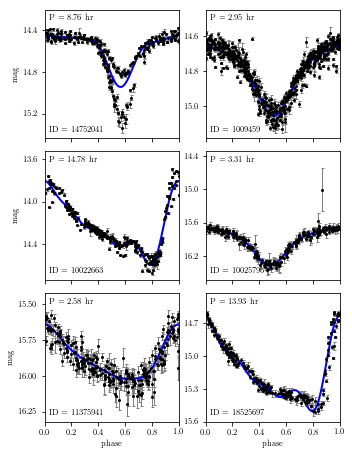

In [7]:
# select a subset of the full dataset
ids = [14752041, 1009459, 10022663, 10025796, 11375941, 18525697]

# Compute the best frequencies
results = compute_best_frequencies(ids, n_eval=10000, n_retry=5)

# Plot the phased light-curves
myprettyplot = plot_lightcurves(results, ids)

## Solution

In [8]:
# read data and process the first 100 stars
data = fetch_LINEAR_sample()
Nlightcurve = 100

# actually, I am brave and will do all 7009! 
# note added in proof: it took about 5 hours 
# Nlightcurve = data.ids[:-1].size

ids = data.ids[:Nlightcurve]
results = compute_best_frequencies(ids, n_eval=10000, n_retry=5)

omegas = np.zeros(len(ids))
for i in range(len(ids)):
    # get the data and best-fit angular frequency
    t, y, dy = data[ids[i]].T
    omega, power = results[ids[i]]
    omega_best = omega[np.argmax(power)]
    omegas[i] = omega_best
    print(" - Star #%4d: omega_0, T_0 = %.10g, %.10g" % (i, omega_best, (2 * np.pi / omega_best * 24.)))


@pickle_results: computing results and saving to 'LINEAR_LS.pkl'
    - args match:   False
    - kwargs match: True
 - computing power for 10003298 (196 points)
 - computing power for 10004892 (269 points)
 - computing power for 10013411 (170 points)
 - computing power for 10021274 (214 points)
 - computing power for 10022663 (246 points)
 - computing power for 10025796 (233 points)
 - computing power for 10028253 (38 points)
 - computing power for 10030349 (255 points)
 - computing power for 10032668 (193 points)
 - computing power for 10038903 (227 points)
 - computing power for 10040133 (257 points)
 - computing power for 10040491 (228 points)
 - computing power for 10045187 (229 points)
 - computing power for 10045615 (101 points)
 - computing power for 10046720 (136 points)
 - computing power for 10047498 (221 points)
 - computing power for 1004849 (607 points)
 - computing power for 1005497 (607 points)
 - computing power for 10064356 (291 points)
 - computing power for 10066464 

 - Star #  85: omega_0, T_0 = 20.3776465, 7.400091435
 - Star #  86: omega_0, T_0 = 11.23552602, 13.42139631
 - Star #  87: omega_0, T_0 = 149.4022274, 1.00933199
 - Star #  88: omega_0, T_0 = 10.12829022, 14.88863807
 - Star #  89: omega_0, T_0 = 47.11060632, 3.200902284
 - Star #  90: omega_0, T_0 = 11.31414375, 13.32813606
 - Star #  91: omega_0, T_0 = 46.88253125, 3.216474097
 - Star #  92: omega_0, T_0 = 10.14641021, 14.86204916
 - Star #  93: omega_0, T_0 = 49.30259111, 3.058590714
 - Star #  94: omega_0, T_0 = 6.489508106, 23.23696109
 - Star #  95: omega_0, T_0 = 56.54226528, 2.666968623
 - Star #  96: omega_0, T_0 = 50.59428576, 2.980503531
 - Star #  97: omega_0, T_0 = 12.04101654, 12.52356451
 - Star #  98: omega_0, T_0 = 45.47848749, 3.315775341
 - Star #  99: omega_0, T_0 = 40.86776995, 3.689862392


Convert frequencies to periods (in hours):

In [9]:
TT = (2 * np.pi / omegas * 24.)

Construct and plot the histogram of periods:

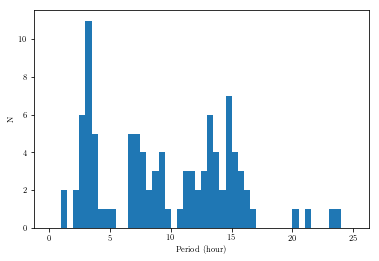

In [10]:
n, bins, patches = plt.hist(TT, 50, range=(0,25))
plt.xlabel('Period (hour)')
plt.ylabel('N')
plt.show()

Now pick 6 ids close to the first and second peaks (determined by eyeballing of the above diagram):

In [11]:
ids_peak1 = ids[(TT >= 3) & (TT < 3.5)][:6]
ids_peak1

array([10025796, 10101561, 10127760, 10178648, 10195209, 10304077])

In [12]:
ids_peak2 = ids[(TT >= 14) & (TT < 16)][:6]
ids_peak2

array([10022663, 10040133, 10046720,  1005497, 10064356, 10066464])

And plot the two diagrams:

 - omega_0 = 45.55493503
 - omega_0 = 44.9335195
 - omega_0 = 45.77922442
 - omega_0 = 47.68349511
 - omega_0 = 44.99004599
 - omega_0 = 49.51997338


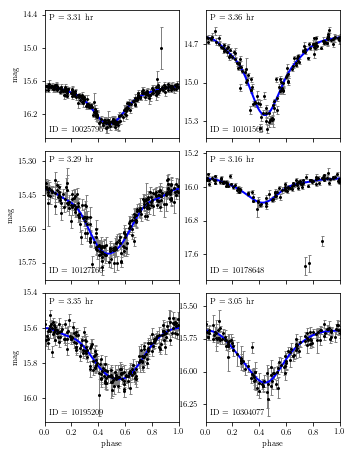

In [14]:
p1 = plot_lightcurves(results, ids_peak1)

 - omega_0 = 10.20062676
 - omega_0 = 10.29120901
 - omega_0 = 10.0363784
 - omega_0 = 9.613121674
 - omega_0 = 10.00077894
 - omega_0 = 9.448396134


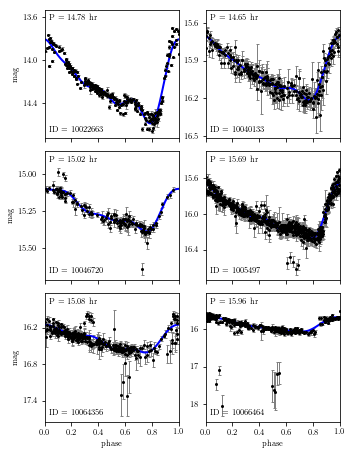

In [15]:
p2 = plot_lightcurves(results, ids_peak2)